In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt

import project_path # So that we can import JankAI
from JankAI.cnn import Conv2dFunctionWrapped, MaxPooling

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class JankAICNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2dFunctionWrapped(10, kernel_size=5)
        #self.conv1 = Conv2d(10, kernel_size=5)
        # (28x28) gets convolved down to (24x24) x 10 channels
        self.pooling = MaxPooling(4)
        # Then max pooling drops down to (6x6) x 10 channels
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(6 * 6 * 10, 10)
        # Want 10 outputs
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.squeeze()
        x = F.relu(self.conv1(x))
        x = self.pooling(x)
        x = x.view(-1, 6 * 6 * 10)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.log_softmax(x)
        return x


In [4]:
network = JankAICNN()
network= network.to(device)
network

JankAICNN(
  (conv1): Conv2dFunctionWrapped()
  (pooling): MaxPooling()
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=360, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [5]:
train_batch_size=32
test_batch_size=1000
n_epochs = 10
log_interval = 100

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        train=True,
        root="../data",
        download=True,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=train_batch_size,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        train=False,
        root="../data",
        download=True,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=test_batch_size,
)

optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

In [6]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target, reduction="mean")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            percentage_complete = 100.0 * batch_idx/len(train_loader)
            print(
                f"Epoch {epoch} ({percentage_complete:.2f}%)\tLoss:{loss.item():.6f}"
            )


def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction="mean").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    accuracy_percentage = 100.0 * correct / len(test_loader.dataset)
    print(
        f"\nTest set: Avg. loss: {test_loss:.6f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy_percentage:.2f}%)\n"
    )


/home/tom/.local/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


ℙ(0)=0.10339   ℙ(1)=0.09130   ℙ(2)=0.09432   ℙ(3)=0.10414   ℙ(4)=0.10679   ℙ(5)=0.10336   ℙ(6)=0.11270   ℙ(7)=0.09345   ℙ(8)=0.08719   ℙ(9)=0.10337   

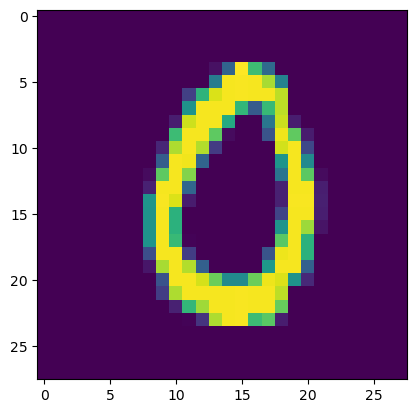

In [7]:
network.eval()
for idx, (data, target) in enumerate(test_loader):
    if idx == 1:
        out_data = data.to(device)
        out_target = target.to(device)
        out_pred = network(out_data)
sample_idx = 1
plt.imshow(out_data[sample_idx,:,:].cpu().squeeze())
prediction = torch.exp(out_pred[sample_idx,:]).cpu()
for idx, prob in enumerate(prediction.tolist()):
    print(f"ℙ({idx})={prob:.5f}", end = "   ")

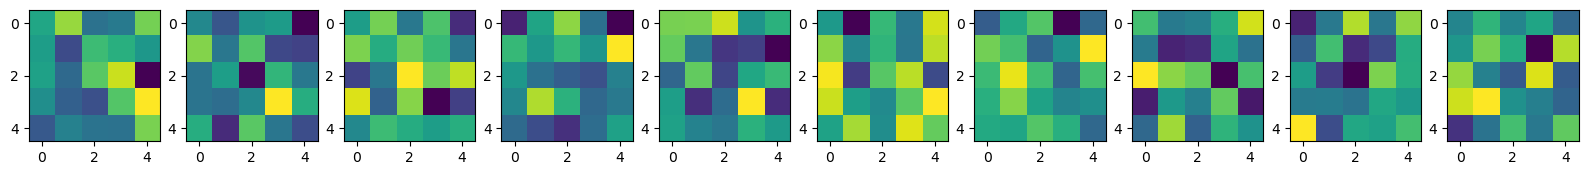

In [8]:
fig, ax = plt.subplots(1,10, figsize=(20, 200))
for i in range(10):
    ax[i].imshow(network.conv1.kernels[i,:,:].cpu().detach().squeeze())

In [9]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.002304, Accuracy: 949/10000 (9.49%)

Epoch 1 (0.00%)	Loss:2.315018
Epoch 1 (5.33%)	Loss:2.195066
Epoch 1 (10.67%)	Loss:1.590152
Epoch 1 (16.00%)	Loss:0.928249
Epoch 1 (21.33%)	Loss:0.866735
Epoch 1 (26.67%)	Loss:1.414774
Epoch 1 (32.00%)	Loss:0.612049
Epoch 1 (37.33%)	Loss:0.724789
Epoch 1 (42.67%)	Loss:0.732679
Epoch 1 (48.00%)	Loss:0.492647
Epoch 1 (53.33%)	Loss:0.836311
Epoch 1 (58.67%)	Loss:0.479070
Epoch 1 (64.00%)	Loss:0.769536
Epoch 1 (69.33%)	Loss:0.610459
Epoch 1 (74.67%)	Loss:0.474383
Epoch 1 (80.00%)	Loss:0.503624
Epoch 1 (85.33%)	Loss:0.366585
Epoch 1 (90.67%)	Loss:0.602464
Epoch 1 (96.00%)	Loss:0.611886

Test set: Avg. loss: 0.000267, Accuracy: 9295/10000 (92.95%)

Epoch 2 (0.00%)	Loss:0.603982
Epoch 2 (5.33%)	Loss:0.512375
Epoch 2 (10.67%)	Loss:0.593176
Epoch 2 (16.00%)	Loss:0.358895
Epoch 2 (21.33%)	Loss:0.302018
Epoch 2 (26.67%)	Loss:0.670923
Epoch 2 (32.00%)	Loss:0.213550
Epoch 2 (37.33%)	Loss:0.366864
Epoch 2 (42.67%)	Loss:0.361051
Epoch 2 (48.

ℙ(0)=0.99452   ℙ(1)=0.00000   ℙ(2)=0.00021   ℙ(3)=0.00004   ℙ(4)=0.00003   ℙ(5)=0.00001   ℙ(6)=0.00436   ℙ(7)=0.00000   ℙ(8)=0.00054   ℙ(9)=0.00029   

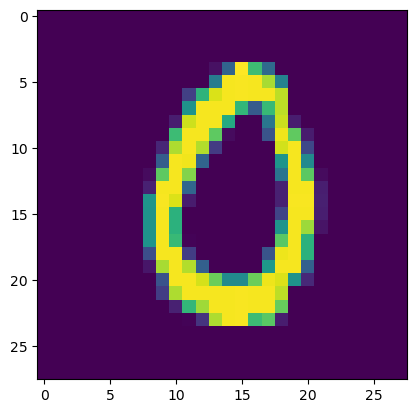

In [10]:
network.eval()
for idx, (data, target) in enumerate(test_loader):
    if idx == 1:
        out_data = data.to(device)
        out_target = target.to(device)
        out_pred = network(out_data)
sample_idx = 1
plt.imshow(out_data[sample_idx,:,:].cpu().squeeze())
prediction = torch.exp(out_pred[sample_idx,:]).cpu()
for idx, prob in enumerate(prediction.tolist()):
    print(f"ℙ({idx})={prob:.5f}", end = "   ")

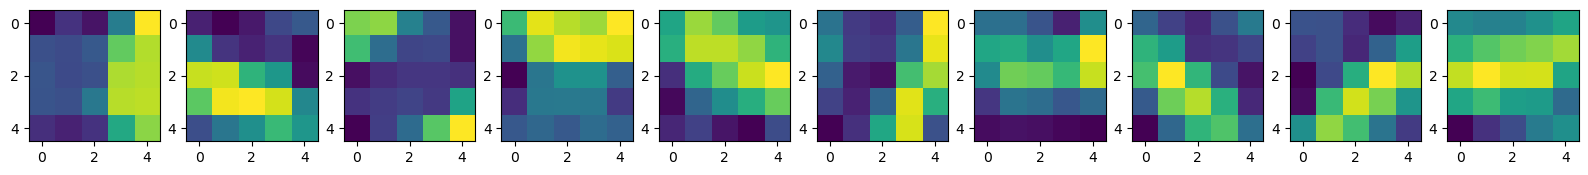

In [11]:
fig, ax = plt.subplots(1,10, figsize=(20, 200))
for i in range(10):
    ax[i].imshow(network.conv1.kernels[i,:,:].cpu().detach().squeeze())

In [12]:
print(network.conv1.kernels.shape)
print(network.fc1.weight.shape)

torch.Size([10, 5, 5])
torch.Size([10, 360])
